In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten 
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

In [3]:
from skimage import io

# read the image stack
# Original values in tif images are scaled between 0-255
demand_img = io.imread('inputDBY_24.tif')
demand_img = np.array(demand_img)
print(demand_img.shape)

LastIterLine_img = io.imread('LastIterLine_24.tif')
LastIterLine_img = np.array(LastIterLine_img)
print(LastIterLine_img.shape)

LastIterRU_img = io.imread('LastIterRU_24.tif')
LastIterRU_img = np.array(LastIterRU_img)
print(LastIterRU_img.shape)

LastIterRD_img = io.imread('LastIterRD_24.tif')
LastIterRD_img = np.array(LastIterRD_img)
print(LastIterRD_img.shape)

Nunits=10
Nbus=32
Nbranch=34
Horizon=24
#n_scenario=np.size(demand_img,0)

(2000, 32, 32, 3)
(2000, 34, 24)
(2000, 10, 23)
(2000, 10, 23)


In [4]:
# normalizing between 0-1
demand_img=(demand_img/255)
LastIterLine_img=(LastIterLine_img/255)   
LastIterRU_img=(LastIterRU_img/255)
LastIterRD_img=(LastIterRD_img/255)

In [5]:
#converting to original values
#as input was converted to images (0 to 255)
maxDem=355.1825
maxcostB=57.4999
maxYbus=157.7124
#maxcostA=0.0802

demand_img[0:,0:,0:,0]=demand_img[0:,0:,0:,0]*maxDem
demand_img[0:,0:,0:,1]=demand_img[0:,0:,0:,1]*maxcostB
demand_img[0:,0:,0:,2]=demand_img[0:,0:,0:,2]*maxYbus
#demand_img[0:,0:,0:,1]=demand_img[0:,0:,0:,1]*maxcostA

In [6]:
#dataset for training

demand_img_train=demand_img[0:1600,0:,0:,0:]
LastIterLine_img_train=LastIterLine_img[0:1600,0:,0:]
LastIterRU_img_train=LastIterRU_img[0:1600,0:,0:]
LastIterRD_img_train=LastIterRD_img[0:1600,0:,0:]
print(demand_img_train.shape)
print(LastIterLine_img_train.shape)
print(LastIterRU_img_train.shape)
print(LastIterRD_img_train.shape)

#normalizing training data
#finding the stat of training data
maxD=np.amax(demand_img_train[0:,0:,0:,0])
maxB=np.amax(demand_img_train[0:,0:,0:,1])
maxY=np.amax(demand_img_train[0:,0:,0:,2])
#maxA=np.amax(demand_img_train[0:,0:,0:,2])

demand_img_train[0:,0:,0:,0]=demand_img_train[0:,0:,0:,0]/maxD
demand_img_train[0:,0:,0:,1]=demand_img_train[0:,0:,0:,1]/maxB
demand_img_train[0:,0:,0:,2]=demand_img_train[0:,0:,0:,2]/maxY
#demand_img[0:,0:,0:,2]=demand_img[0:,0:,0:,2]/maxA #this channel is zero for linear cost (0 division)

#Reshaping training data
n_scenario=np.size(demand_img_train,0)
#n_training_scenario=np.size(demand_img_train,0)
x_train_demand_line=np.reshape(demand_img_train,(n_scenario,Nbus,32,3))
x_train_demand_rampRU=np.copy(x_train_demand_line)
x_train_demand_rampRD=np.copy(x_train_demand_line)
y_train_line=np.reshape(LastIterLine_img_train,(n_scenario,Nbranch*24),'F')
y_train_rampRU=np.reshape(LastIterRU_img_train,(n_scenario,Nunits*23),'F')
y_train_rampRD=np.reshape(LastIterRD_img_train,(n_scenario,Nunits*23),'F')

print(x_train_demand_line.shape)
print(y_train_line.shape)
print(y_train_rampRU.shape)
print(y_train_rampRD.shape)

(1600, 32, 32, 3)
(1600, 34, 24)
(1600, 10, 23)
(1600, 10, 23)
(1600, 32, 32, 3)
(1600, 816)
(1600, 230)
(1600, 230)


In [7]:
#dataset for testing

demand_img_test=demand_img[1600:,0:,0:,0:]
LastIterLine_img_test=LastIterLine_img[1600:,0:,0:]
LastIterRU_img_test=LastIterRU_img[1600:,0:,0:]
LastIterRD_img_test=LastIterRD_img[1600:,0:,0:]
print(demand_img_test.shape)
print(LastIterLine_img_test.shape)
print(LastIterRU_img_test.shape)
print(LastIterRD_img_test.shape)

#normalizing testing data
#finding the stat of testing data
maxD=np.amax(demand_img_test[0:,0:,0:,0])
maxB=np.amax(demand_img_test[0:,0:,0:,1])
maxY=np.amax(demand_img_test[0:,0:,0:,2])
#maxA=np.amax(demand_img_test[0:,0:,0:,2])

demand_img_test[0:,0:,0:,0]=demand_img_test[0:,0:,0:,0]/maxD
demand_img_test[0:,0:,0:,1]=demand_img_test[0:,0:,0:,1]/maxB
demand_img_test[0:,0:,0:,2]=demand_img_test[0:,0:,0:,2]/maxY

#Reshaping testing data
n_scenario=np.size(demand_img_test,0)
#n_test_scenario=np.size(demand_img_test,0)
x_test_demand_line=np.reshape(demand_img_test,(n_scenario,Nbus,32,3))
x_test_demand_rampRU=np.copy(x_test_demand_line)
x_test_demand_rampRD=np.copy(x_test_demand_line)
y_test_line=np.reshape(LastIterLine_img_test,(n_scenario,Nbranch*24),'F')
y_test_rampRU=np.reshape(LastIterRU_img_test,(n_scenario,Nunits*23),'F')
y_test_rampRD=np.reshape(LastIterRD_img_test,(n_scenario,Nunits*23),'F')

n_test_scenario=np.size(demand_img_test,0)

print(x_test_demand_line.shape)
print(y_test_line.shape)
print(y_test_rampRU.shape)
print(y_test_rampRD.shape)

(400, 32, 32, 3)
(400, 34, 24)
(400, 10, 23)
(400, 10, 23)
(400, 32, 32, 3)
(400, 816)
(400, 230)
(400, 230)


In [8]:
import tensorflow.keras.backend as K

def f2(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f2 = 5*p*r / (4*p+r+K.epsilon())
    return K.mean(f2)

def f2_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)
    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())
    f2 = 5*p*r / (4*p+r+K.epsilon())
    return 1 - K.mean(f2)

from tensorflow.keras.callbacks import EarlyStopping
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    min_delta=0.001, 
    mode='min',
    verbose=1
)

In [9]:
# importing EfficientNet Architecture with imagenet weights
import efficientnet.tfkeras as enet
base = enet.EfficientNetB7(include_top=False, weights='imagenet',pooling='avg')

In [10]:
# training and finetunig the modified EfficientNet architecture with imagenet weights
model_line = Sequential()
model_line.add(base)
model_line.add(Flatten())
model_line.add(Dense(1024, activation='relu'))
model_line.add(Dense(Nbranch*24, activation='sigmoid'))

for layer in model_line.layers[:-3]:
    layer.trainable=False
model_line.compile(loss=f2_loss, optimizer=Adam(), metrics=['accuracy',f2])
history_line =model_line.fit(x_train_demand_line, y_train_line, batch_size=50, epochs=10,verbose=1,validation_split=0.1)

# Unfreeze the base model
for layer in model_line.layers[-5:]:
    layer.trainable=True

model_line.compile(loss=f2_loss, optimizer=Adam(0.00001), metrics=['accuracy',f2])   
history_line =model_line.fit(x_train_demand_line, y_train_line, batch_size=50, epochs=30,verbose=1,validation_split=0.1,callbacks=[custom_early_stopping])

Train on 1440 samples, validate on 160 samples
Epoch 1/10
1440/1440 [==============================] - 30s 21ms/sample - loss: 0.9890 - accuracy: 0.0285 - f2: 0.0110 - val_loss: 0.9804 - val_accuracy: 0.0000e+00 - val_f2: 0.0197
Epoch 2/10
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.9886 - accuracy: 0.0236 - f2: 0.0114 - val_loss: 0.9804 - val_accuracy: 0.0000e+00 - val_f2: 0.0197
Epoch 3/10
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.9886 - accuracy: 0.0292 - f2: 0.0115 - val_loss: 0.9804 - val_accuracy: 0.0000e+00 - val_f2: 0.0197
Epoch 4/10
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.9886 - accuracy: 0.0139 - f2: 0.0114 - val_loss: 0.9804 - val_accuracy: 0.0000e+00 - val_f2: 0.0197
Epoch 5/10
1440/1440 [==============================] - 9s 6ms/sample - loss: 0.9887 - accuracy: 0.0160 - f2: 0.0113 - val_loss: 0.9804 - val_accuracy: 0.0000e+00 - val_f2: 0.0197
Epoch 6/10
1440/1440 [=============================

In [11]:
# training and finetunig the modified EfficientNet architecture with imagenet weights

model_rampRU = Sequential()
model_rampRU.add(base)
model_rampRU.add(Flatten())
model_rampRU.add(Dense(256, activation='relu'))
model_rampRU.add(Dense(Nunits*23, activation='sigmoid'))

for layer in model_rampRU.layers[:-3]:
    layer.trainable=False
model_rampRU.compile(loss=f2_loss, optimizer=Adam(), metrics=['accuracy',f2])
history_rampRU =model_rampRU.fit(x_train_demand_rampRU, y_train_rampRU, batch_size=50, epochs=10,verbose=1,validation_split=0.1)

# Unfreeze the base model
for layer in model_rampRU.layers[-5:]:
    layer.trainable=True

model_rampRU.compile(loss=f2_loss, optimizer=Adam(0.00001), metrics=['accuracy',f2])
history_rampRU =model_rampRU.fit(x_train_demand_rampRU, y_train_rampRU, batch_size=50, epochs=30,verbose=1,validation_split=0.1,callbacks=[custom_early_stopping])

Train on 1440 samples, validate on 160 samples
Epoch 1/10
1440/1440 [==============================] - 63s 43ms/sample - loss: 0.8939 - accuracy: 0.0431 - f2: 0.1084 - val_loss: 0.8869 - val_accuracy: 0.0562 - val_f2: 0.1056
Epoch 2/10
1440/1440 [==============================] - 35s 24ms/sample - loss: 0.8835 - accuracy: 0.0694 - f2: 0.1182 - val_loss: 0.8846 - val_accuracy: 0.0875 - val_f2: 0.1081
Epoch 3/10
1440/1440 [==============================] - 32s 22ms/sample - loss: 0.8822 - accuracy: 0.0708 - f2: 0.1188 - val_loss: 0.8841 - val_accuracy: 0.0875 - val_f2: 0.1090
Epoch 4/10
1440/1440 [==============================] - 35s 24ms/sample - loss: 0.8815 - accuracy: 0.0569 - f2: 0.1193 - val_loss: 0.8840 - val_accuracy: 0.0688 - val_f2: 0.1086
Epoch 5/10
1440/1440 [==============================] - 36s 25ms/sample - loss: 0.8814 - accuracy: 0.0701 - f2: 0.1193 - val_loss: 0.8840 - val_accuracy: 0.0500 - val_f2: 0.1091
Epoch 6/10
1440/1440 [==============================] - 36s 25m

In [12]:
# training and finetunig the modified EfficientNet architecture with imagenet weights

model_rampRD = Sequential()
model_rampRD.add(base)
model_rampRD.add(Flatten())
model_rampRD.add(Dense(256, activation='relu'))
model_rampRD.add(Dense(Nunits*23, activation='sigmoid'))

for layer in model_rampRD.layers[:-3]:
    layer.trainable=False
model_rampRD.compile(loss=f2_loss, optimizer=Adam(), metrics=['accuracy',f2])
history_rampRD =model_rampRD.fit(x_train_demand_rampRD, y_train_rampRD, batch_size=50, epochs=10,verbose=1,validation_split=0.1)

# Unfreeze the base model
for layer in model_rampRD.layers[-5:]:
    layer.trainable=True

model_rampRD.compile(loss=f2_loss, optimizer=Adam(0.00001), metrics=['accuracy',f2])
history_rampRD =model_rampRD.fit(x_train_demand_rampRD, y_train_rampRD, batch_size=50, epochs=30,verbose=1,validation_split=0.1,callbacks=[custom_early_stopping])

Train on 1440 samples, validate on 160 samples
Epoch 1/10
1440/1440 [==============================] - 73s 51ms/sample - loss: 0.8978 - accuracy: 0.0326 - f2: 0.1081 - val_loss: 0.8858 - val_accuracy: 0.0375 - val_f2: 0.1112
Epoch 2/10
1440/1440 [==============================] - 51s 35ms/sample - loss: 0.8802 - accuracy: 0.0500 - f2: 0.1235 - val_loss: 0.8727 - val_accuracy: 0.0437 - val_f2: 0.1207
Epoch 3/10
1440/1440 [==============================] - 51s 36ms/sample - loss: 0.8731 - accuracy: 0.0521 - f2: 0.1297 - val_loss: 0.8687 - val_accuracy: 0.0562 - val_f2: 0.1247
Epoch 4/10
1440/1440 [==============================] - 43s 30ms/sample - loss: 0.8697 - accuracy: 0.0542 - f2: 0.1327 - val_loss: 0.8685 - val_accuracy: 0.0625 - val_f2: 0.1250
Epoch 5/10
1440/1440 [==============================] - 51s 35ms/sample - loss: 0.8693 - accuracy: 0.0590 - f2: 0.1328 - val_loss: 0.8683 - val_accuracy: 0.0625 - val_f2: 0.1249
Epoch 6/10
1440/1440 [==============================] - 52s 36m

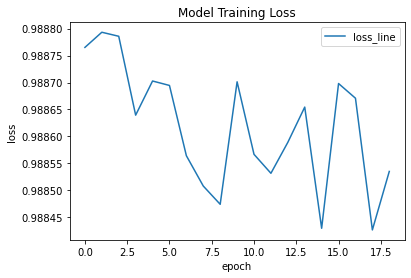

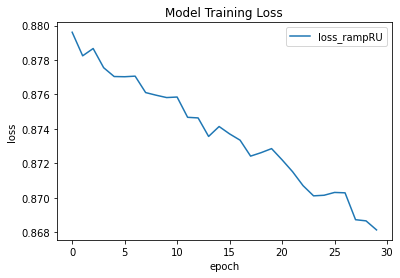

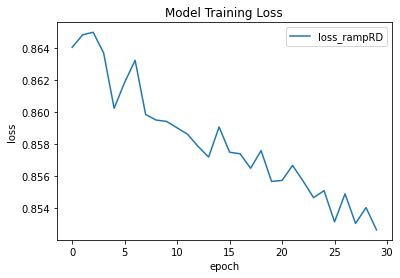

In [13]:
#print(history.history.keys())
import matplotlib.pyplot as plt

plt.plot(history_line.history['loss'])
plt.title('Model Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss_line'], loc='upper right')          
plt.show()

plt.plot(history_rampRU.history['loss'])
plt.title('Model Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss_rampRU'], loc='upper right')          
plt.show()

plt.plot(history_rampRD.history['loss'])
plt.title('Model Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss_rampRD'], loc='upper right')          
plt.show()

In [14]:
# prediction 
y_pred_line=model_line.predict(x_test_demand_line)
y_pred_rampRU=model_rampRU.predict(x_test_demand_rampRU)
y_pred_rampRD=model_rampRD.predict(x_test_demand_rampRD)
print(y_pred_line.shape)
print(y_pred_rampRU.shape)
print(y_pred_rampRD.shape)

(400, 816)
(400, 230)
(400, 230)


In [15]:
from sklearn.metrics import confusion_matrix

#testing the Branch classifier
y_test=np.reshape(y_test_line,np.size(y_test_line,0)*np.size(y_test_line,1),'c')
y_pred=np.reshape(y_pred_line,np.size(y_test_line,0)*np.size(y_test_line,1),'c')

probability_fitering=np.array([0.999])

y_predline=np.copy(y_pred)
y_predline[y_predline >= probability_fitering] = 1
y_predline[y_predline < probability_fitering] = 0
print(confusion_matrix(y_test, y_predline))

#testing the Ramp Up classifier
y_test=np.reshape(y_test_rampRU,np.size(y_test_rampRU,0)*np.size(y_test_rampRU,1),'c')
y_pred=np.reshape(y_pred_rampRU,np.size(y_test_rampRU,0)*np.size(y_test_rampRU,1),'c')

y_predRU=np.copy(y_pred)
y_predRU[y_predRU >= probability_fitering] = 1
y_predRU[y_predRU < probability_fitering] = 0
print(confusion_matrix(y_test, y_predRU))

#testing the Ramp Down classifier
y_test=np.reshape(y_test_rampRD,np.size(y_test_rampRD,0)*np.size(y_test_rampRD,1),'c')
y_pred=np.reshape(y_pred_rampRD,np.size(y_test_rampRD,0)*np.size(y_test_rampRD,1),'c')

y_predRD=np.copy(y_pred)
y_predRD[y_predRD >= probability_fitering] = 1
y_predRD[y_predRD < probability_fitering] = 0
print(confusion_matrix(y_test, y_predRD))

[[321242   3734]
 [   799    625]]
[[66761 21928]
 [  431  2880]]
[[71515 17698]
 [  634  2153]]


In [16]:
#ouput data reshaping
n_test_scenario=np.size(demand_img_test,0)
y_predline=np.reshape(y_predline,(n_test_scenario,Nbranch*24),'c')
y_predRU=np.reshape(y_predRU,(n_test_scenario,Nunits*23),'c')
y_predRD=np.reshape(y_predRD,(n_test_scenario,Nunits*23),'c')
print(y_predline.shape)
print(y_predRU.shape)
print(y_predRD.shape)

#Breaking each scenario into row and columns
y_predline=np.reshape(y_predline,(n_test_scenario,Nbranch,24),'F')
y_predRU=np.reshape(y_predRU,(n_test_scenario,Nunits,23),'F')
y_predRD=np.reshape(y_predRD,(n_test_scenario,Nunits,23),'F')
print(y_predline.shape)
print(y_predRU.shape)
print(y_predRD.shape)

(400, 816)
(400, 230)
(400, 230)
(400, 34, 24)
(400, 10, 23)
(400, 10, 23)


In [17]:
#saving the trained model
model_line.save("model_line_24_Last.h5")
model_rampRU.save("model_rampRU_24_Last.h5")
model_rampRD.save("model_rampRD_24_Last.h5")

In [18]:
#saving the predicted result back to image format
from skimage import io
io.imsave('predicted_branch_const_24_Last.tif',y_predline)
io.imsave('predicted_rampRU_const_24_Last.tif',y_predRU)
io.imsave('predicted_rampRD_const_24_Last.tif',y_predRD)